In [1]:
from glob import glob
from os.path import join
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import nengo
import nengo_dl
import nengo_loihi

from nxsdk.graph.monitor.probes import PerformanceProbeCondition
from nxsdk.api.n2a import ProbeParameter

# All Nengo Loihi models should call this before model construction
nengo_loihi.set_defaults() #changes default neuron parameters for better performance on Loihi

# To provide repeatable behavior
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
def LoadModel(name="classifier"):
    structure = Path(name+"Structure.json").read_text()
    model = keras.models.model_from_json(structure)
    model.load_weights(name+"Weights.h5")
    return model

def LoadData(batchNum=0, directory="Development"):
    fileList = glob(join("Dataset", directory, "test*"))
    dataBatch = np.load(fileList[batchNum])
    return dataBatch["data"], dataBatch["isFace"], dataBatch["labels"]

In [3]:
data, isFace, labels = LoadData(directory="Training")
data = data.astype('float32') / 255

model = LoadModel()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 31, 31, 16)        432       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 8)         1152      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 4)           288       
_________________________________________________________________
flatten (Flatten)            (None, 196)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 197       
Total params: 2,069
Trainable params: 2,069
Non-trainable params: 0
___________________________________________________________

In [4]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.evaluate(data, isFace) #get loss and accuracy over test data

26/26 [==============================] - 0s 14ms/step - accuracy: 0.9841 - loss: 0.1790


[0.17899900674819946, 0.9841075539588928]

In [39]:
subset = np.concatenate([data[:10],data[-10:]])
predictions = model.predict(subset)[:,0]
print("Prediction: ", predictions)
print("ground truth: ", np.concatenate([isFace[:10], isFace[-10:]]))

Prediction:  [3.3255105  3.3052843  0.81340384 7.0870447  1.8715216  2.8892748
 2.7007937  1.264092   7.6157885  4.796785   0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
ground truth:  [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]


In [7]:
activation = keras.activations.relu

In [8]:
inLayer = model.layers[0]
firstConv = model.layers[1]
outLayer = model.layers[-1]

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

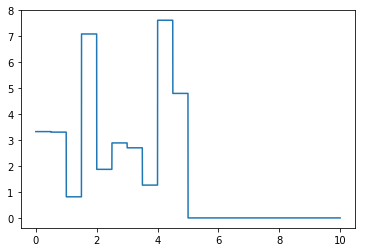

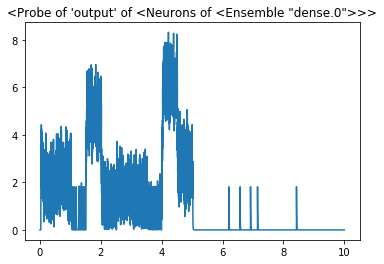

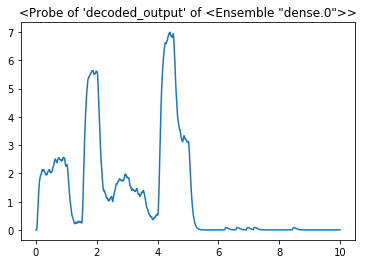

In [44]:
# FLAT SIMULATION FOR DEBUGGING
converter = nengo_dl.Converter(model,
                               swap_activations={activation: nengo.SpikingRectifiedLinear()},
                               scale_firing_rates=100,
                               synapse=0.005)
net = converter.net

present_time = 0.5

#add spike probes to network
with net:
    outProbe = nengo.Probe(net.all_ensembles[-1], synapse=nengo.Alpha(0.05))
    
    #set input to Simulator
    converter.inputs[inLayer].output = nengo.processes.PresentInput(subset, present_time)
    
    nengo_loihi.add_params(net)  # allow on_chip to be set

net.all_objects

run_time = present_time*len(predictions)
dt = 0.001

with nengo.Simulator(net, dt=dt) as flatSim:
    flatSim.run(run_time)
    
timeAx = flatSim.trange()

#Plot non-spiking output
plt.figure()
plt.plot(timeAx, np.repeat(predictions, int(present_time/dt)))

for probe in net.probes:
    plt.figure()
    plt.plot(timeAx, flatSim.data[probe])
    plt.title(probe)

In [45]:
# Convert to spiking network
nengo_converter = nengo_dl.Converter(model,
                                     swap_activations={activation: nengo_loihi.neurons.LoihiSpikingRectifiedLinear()},
                                     scale_firing_rates=100, synapse=0.005)
snnNet = nengo_converter.net

In [46]:
present_time = 0.5

#add spike probes to network
with snnNet:
    outProbe = nengo.Probe(snnNet.all_ensembles[-1], synapse=nengo.Alpha(0.05))
    
    #set input to Simulator
    nengo_converter.inputs[inLayer].output = nengo.processes.PresentInput(subset, present_time)
    
    nengo_loihi.add_params(snnNet)  # allow on_chip to be set
    snnNet.config[nengo_converter.layers[firstConv].ensemble].on_chip = False

snnNet.all_objects

[<Ensemble "conv2d.0" at 0x7f5cefda3470>,
 <Ensemble "conv2d_1.0" at 0x7f5cefacf9e8>,
 <Ensemble "conv2d_2.0" at 0x7f5cefacfc88>,
 <Ensemble "dense.0" at 0x7f5cefac35f8>,
 <Probe at 0x7f5cefad7d30 of 'output' of <Neurons of <Ensemble "dense.0">>>,
 <Probe at 0x7f5cefaef588 of 'decoded_output' of <Ensemble "dense.0">>,
 <Connection at 0x7f5cefacf278 from <Node "input_1"> to <Neurons of <Ensemble "conv2d.0">>>,
 <Connection at 0x7f5cefacf9b0 from <Neurons of <Ensemble "conv2d.0">> to <Neurons of <Ensemble "conv2d_1.0">>>,
 <Connection at 0x7f5cefacf5c0 from <Neurons of <Ensemble "conv2d_1.0">> to <Neurons of <Ensemble "conv2d_2.0">>>,
 <Connection at 0x7f5cefac3438 from <Neurons of <Ensemble "conv2d_2.0">> to <Neurons of <Ensemble "dense.0">>>,
 <Node "input_1" at 0x7f5cefd86358>]

In [47]:
run_time = present_time*len(predictions)
dt = 0.001

with nengo.Simulator(snnNet, dt=dt) as cpuSim:
    cpuSim.run(run_time)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

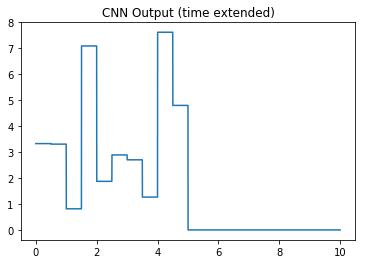

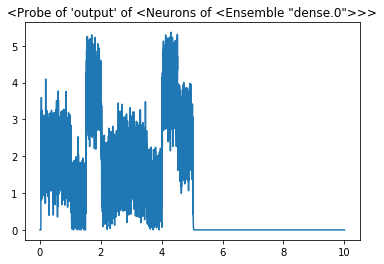

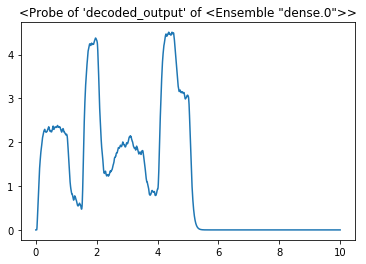

In [49]:
timeAx = cpuSim.trange()

#Plot non-spiking output
plt.figure()
plt.plot(timeAx, np.repeat(predictions, int(present_time/dt)))
plt.title("CNN Output (time extended)")

for probe in snnNet.probes:
    plt.figure()
    plt.plot(timeAx, cpuSim.data[probe])
    plt.title(probe)